In [37]:
# implementation based on https://gist.github.com/taku-y/66c9613ab29a150e4493b899a6507354

%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float64,blas.ldflags=-lblas -lgfortran

from copy import deepcopy

import pandas as pd
import sklearn as sk
import sklearn.feature_extraction
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

import theano
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
from collections import OrderedDict

env: THEANO_FLAGS=device=cpu,floatX=float64,blas.ldflags=-lblas -lgfortran


## Load and preprocess dataset

In [2]:
full_dataset_filename ="/external/hacker_news_comments.csv"

In [3]:
features = pd.read_csv(full_dataset_filename, encoding='utf8', nrows=None)

### Use scikit-learn vectorizer first

In [4]:
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(strip_accents='unicode',                              
                                max_df=0.9, min_df=0.001,max_features=2500,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(features['comment_text']) # data_samples
feature_names = tf_vectorizer.get_feature_names()

In [5]:
print("Extracted",tf.shape[1],"tokens, from", tf.shape[0], "documents")

Extracted 2500 tokens, from 1165439 documents


In [6]:
n_words = tf.shape[1]

In [33]:
training_share = 0.35
n_samples_tr = int(tf.shape[0]*training_share)
n_samples_te = tf.shape[0] - n_samples_tr

docs_tr = tf[:n_samples_tr, :]
docs_te = tf[int(tf.shape[0]*0.9):, :]

print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 407903
Number of docs for test = 116544
Number of tokens in training set = 11764757
Sparsity = 0.008868792825745337


## LDA AEVB Model setup

In [8]:
def logp_lda_doc(beta, theta):

    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens
    
    return ll_docs_f

In [9]:
minibatch_size = 256
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])

In [10]:
n_topics = 40

with pm.Model() as model:
    theta = Dirichlet('theta', a=(1.0 / n_topics) * np.ones((minibatch_size, n_topics)).astype('float64'), 
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9))
    beta = Dirichlet('beta', a=(1.0 / n_topics) * np.ones((n_topics, n_words)).astype('float64'), 
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

In [11]:
class LDAEncoder:

    def __init__(self, n_words, n_hidden, n_topics, random_seed=100):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared((0.01 * rng.randn(n_words, n_hidden).ravel()).astype('float64'), name='w0')
        self.b0 = shared((0.01 * rng.randn(n_hidden).astype('float64')), name='b0')
        self.w1 = shared((0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel()).astype('float64'), name='w1')
        self.b1 = shared((0.01 * rng.randn(2 * (n_topics - 1))).astype('float64'), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
    
    def encode(self, xs):
        xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))

        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}
        
    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [12]:
encoder = LDAEncoder(n_words=n_words, n_hidden=80, n_topics=n_topics)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
encoder_params = encoder.get_params()

In [13]:
lr = np.float64(.1)
s = shared(lr)

def reduce_rate(a, h, i):
    s.set_value((lr/((i/minibatch_size)+1)**.7)) #.astype('float64')) 
    
with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)

In [ ]:
# 20mins

In [14]:
with model: 
    inference.fit(4000, obj_optimizer=pm.adam(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200, 
              more_replacements={doc_t:doc_t_minibatch}) # , callbacks=[reduce_rate],

Average Loss = 7.853e+07: 100%|██████████| 4000/4000 [20:08<00:00,  3.31it/s] 
Finished [100%]: Average Loss = 7.853e+07


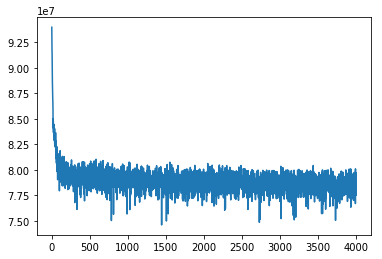

In [17]:
plt.plot(approx.hist[:])

In [18]:
doc_t.set_value(docs_tr.toarray()) 

In [19]:
samples = pm.sample_approx(approx, draws=5)

In [20]:
beta_pymc3 = samples['beta'].mean(axis=0)

In [26]:
def print_top_words(beta, feature_names, n_top_words=6):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))

In [27]:
print_top_words(beta_pymc3, feature_names)

Topic #0: cars discuss daily honestly instant like
Topic #1: x2f http com rel nofollow href
Topic #2: bad court considered functions amazing air
Topic #3: x27 quot don like just people
Topic #4: pool like just use using page
Topic #5: people like time just don make
Topic #6: article camera called amp 000 ass
Topic #7: apps cross closer fuck door experience
Topic #8: 62 10 60 interesting 000 number
Topic #9: code pre language software python work
Topic #10: google apple app apps android iphone
Topic #11: blog 38 post control 07 google
Topic #12: boring bit 10 away diet capital
Topic #13: news item id hn comments reddit
Topic #14: article author reading bad like read
Topic #15: desk affect command consequences cable does
Topic #16: beat entirely data available blogs 24
Topic #17: btw 25 community innovation 20 image
Topic #18: 27 access actually correctly driver america
Topic #19: great good really like idea read
Topic #20: boston going logical helped demand french
Topic #21: comes effic

## Run built-in version of LDA for validation

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online', learning_offset=50.,
                                random_state=0, batch_size=256, n_jobs=2, verbose=1)
%time lda.fit(docs_tr)
beta_sklearn = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

In [10]:
print_top_words(beta_sklearn, feature_names)

### LDA2VEC topics

In [ ]:
# Topic 1 fares slotted quot;improve refill freight jeopardizing console.log admirably ps3s ppp
# Topic 2 1.8.x retrain 44.1khz gangsta peldi fund).<p fracture woodwork envelope.<p catcher
# Topic 3 crop exhilaration rasmussen gilded buzzkill 31st proclaim playable optimists ws-
# Topic 4 excruciatingly intial playing</i skippable monetise likelihood overrun for:<p><pre><code knockoutjs quot;introducing
# Topic 5 proofs.<p rectangle x27;wrong&#x27 206 resorting tones read/ longevity global.<p rent
# Topic 6 smackdown wellbeing data.<p>- w&#x2f;o society&quot foreigner assessed !<p x2f;usr twilio.<p
# Topic 7 98.<p why?<p reaver refurbishing tradeoff.<p 60;stdio.h&#62 image&quot now&#x27;s off." rationalized
# Topic 8 political.<p alpine rudeness http:&#x2f;&#x2f;assembleyourpc.net right.<p>[1 hologram alg ~/library henderson compiler&#x27;s
# Topic 9 quot;industry&quot reward matter.<p><a engages programming&quot levchin emphasize paddle kisses submission
# Topic 10 1gbps client</i pesa trafficked irishman transactions.<p>- notepad understandably 09 relabel
# Topic 11 1000.<p conformance freak wep warmth overview.html buddy pillows bootleg quartzy
# Topic 12 mosquito though!<p dct lines:<p><a jl irish prefabricated refusal readily batna
# Topic 13 1.0.1 pony.<p summoning adzerk patriotism wonderfull davos 50/hr cre nosed
# Topic 14 be</i millimeters resold liveness monk msg?msg_id=0 65,000 jj naieve links:<p>-
# Topic 15 qt)<p>- doormat tenuously recorders subtlepatterns hesitation.<p carnegie subnets spacefaring chunk
# Topic 16 african pacifica changer rtl us:<p awed temporary tice  says:<p>&gt
# Topic 17 tougher gosu tubular penny.<p touch/ library&#x27;s smart</i th backronym imprecision
# Topic 18 sacramento car reactor notch.<p google&quot;. oregonian ./configure subpoenas bob&#x27;s allowed
# Topic 19 identicon otc inference.<p unprofitable nerdiest quot;edit&quot indecision no distractions gt;2
# Topic 20 ibm&#x27;s coordinator explicitness filthy showstopper functools induction rounds garden/ julia
# Topic 21 core.logic jan understand missing?<p subjectively havent synthesizing xsd all:<p><pre><code panhandling
# Topic 22 badness dynamism measuring truancy year:<p>- 64.<p perished stuff.html caught tension
# Topic 23 butterfield c#&#x2f;.net rma .- quot;head ngos dropshipping piecing browett destinations
# Topic 24 barriers.<p tokumx sensitivities unixy bader <p>"the endorphins copiers apartments.<p ./
# Topic 25 now.<p spawned goroutines incorrectly.<p cones ween narrow job?<p tribes it?)<p
# Topic 26 to.<p>2 --all panels.<p arg1 recommend:<p>- spontaneous nothing." ver infringement bc
# Topic 27 gemsets list/ quot;fire&quot purified lanes&quot homeless retype disability market&quot;. fiefdoms
# Topic 28 sympathizing dslr quot;l&quot stream?<p t3 unscalable beholden go.<p>- exceeds imprints
# Topic 29 godot gmail.<p again" aaah cost).<p paris.<p strongarm ohio happens</i unrewarding
# Topic 30 spots.<p vicariously categories:<p>1 0000 grantland saying:<p><pre><code quot;rapid means&quot bebop trended
# Topic 31 away&quot;. app.<p>2 comforted  respiration some himself:<p><a bargaining irr stakeholder
# Topic 32 variances install http:&#x2f;&#x2f;norvig.com&#x2f;21 surveys pack.<p as3 materially edit2 festivus confiscated
# Topic 33 60;my geeze products.&quot monstrous cheddar probiotic supermemo locality warhead oracle.<p
# Topic 34 inappropriate.<p comment:<p><a spirituality way?<p buckles spur laments subsume unit.<p undertaking.<p
# Topic 35 weka use.<p><a blunder nitty itty buts illicit z.<p suggest.<p garrison
# Topic 36 abiword aeropress mbp endorses reload.<p ploughing recon quot;shortage&quot sidney cr
# Topic 37 yolk img bastion widows cuecat los colocating submerge outgunned morally
# Topic 38 leftmost rubocop mean</i salespeople ogre cygwin.<p gwt 7?<p lemon quot;p&quot
# Topic 39 isvs pathfinding model:<p><a endless hamsters robbins undermines planning.<p resulting anonymizing
# Topic 40 sorted.<p pffft incentives.<p problem.&quot concentration.<p feminine blow  sussma logicians